
# **Understanding and Predicting Property Maintenance Fines**

### **Objective:** *To predict whether a given blight ticket will be paid on time*.

Evaluation Metric : **AUC**

**File descriptions**

train.csv - the training set (all tickets issued 2004-2011)

test.csv - the test set (all tickets issued 2012-2016)

addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates.

Note: misspelled addresses may be incorrectly geolocated.


**Data fields**

train.csv & test.csv

ticket_id - unique identifier for tickets

agency_name - Agency that issued the ticket

inspector_name - Name of inspector that issued the ticket

violator_name - Name of the person/organization that the ticket was issued to

violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator

ticket_issued_date - Date and time the ticket was issued
hearing_date - Date and time the violator's hearing was scheduled

violation_code, violation_description - Type of violation

disposition - Judgment and judgement type

fine_amount - Violation fine amount, excluding fees

admin_fee - $20 fee assigned to responsible judgments

state_fee - $10 fee assigned to responsible judgments 

late_fee - 10% fee assigned to responsible judgments 

discount_amount - discount applied, if any clean_up_cost - DPW clean-up or graffiti removal cost 

judgment_amount - Sum of all fines and fees 

grafitti_status - Flag for graffiti violations

**train.csv only**

payment_amount - Amount paid, if any

payment_date - Date payment was made, if it was received

payment_status - Current payment status as of Feb 1 2017

balance_due - Fines and fees still owed

collection_status - Flag for payments in collections

compliance [target variable for prediction] 
 Null = Not responsible
 0 = Responsible, non-compliant
 1 = Responsible, compliant

compliance_detail - More information on why each ticket was marked compliant or non-compliant

In [6]:
# Mounting our google drive to google colab.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Importing all the required modules and setting up the plot styles.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from scipy import stats
from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore")
# pip install --upgrade pandas-profiling
plt.style.use('seaborn')
pd.set_option('float_format', '{:.2f}'.format)
%matplotlib inline

In [0]:
# Defining a function - reduce_memory that will reduce the size of our data
# without loosing any information by converting the data types of the columns .

def reduce_memory(df):
  ''' This function take dataframe as an input and return a dataframe .This function convert the
   data types of the columns in order to reduce the overall size of the dataframe'''
  start=time.time()
  initial_memory_usage=df.memory_usage().sum()/1024**2
  for cols in df.columns :
    if df[cols].dtype == object:
      pass  
    elif str(df[cols].dtype)[:3] =='int':
      cols_min,cols_max=df[cols].min(),df[cols].max()
      for data_type in [np.int8,np.int16,np.int32,np.int64]:
        if cols_min > np.iinfo(data_type).min and cols_max < np.iinfo(data_type).max:
          df[cols]=df[cols].astype(data_type)
          break
    elif str(df[cols].dtype)[:5] =='float':
      cols_min,cols_max=df[cols].min(),df[cols].max()
      for data_type in [np.float16,np.float32,np.float64]:
        if cols_min > np.finfo(data_type).min and cols_max < np.finfo(data_type).max:
          df[cols]=df[cols].astype(data_type)
          break
    
  final_memory_usage=df.memory_usage().sum()/1024**2
  print('Final DataFrame memory_usage:{}\n Total memory saved (%): {}'.format(final_memory_usage,((initial_memory_usage-final_memory_usage)*100)/initial_memory_usage))
  end=time.time()
  print('Total time taken to reduce DataFrame : {} ms'.format((end-start)*1000))
  return df 


**Loading our dataset and performing data cleaning and preprocessing.**

In [9]:
# Loading our data and reducing its size using the above defined function.

initial_df=pd.read_csv('/content/drive/My Drive/train (1).csv',encoding='ISO-8859-1',parse_dates=['ticket_issued_date','hearing_date'])
df1=reduce_memory(initial_df)
latlon_df=pd.read_csv('/content/drive/My Drive/latlons.csv')
address_df=pd.read_csv('/content/drive/My Drive/addresses.csv')

Final DataFrame memory_usage:47.74220275878906
 Total memory saved (%): 26.470538469311737
Total time taken to reduce DataFrame : 97.41330146789551 ms


In [0]:
# Merging the address and latitude/longitude dataframe to our main dataframe .

x=pd.merge(df1,address_df,on='ticket_id',how='left')
df=pd.merge(x,latlon_df,on='address',how='left')

In [11]:
# Using Pandas profiling to get an overview on the whole data

report = ProfileReport(df,minimal=True,title="My dataframe report")
report.to_file('/content/drive/My Drive/my_report.html')

In [0]:
# Droping rows with Nan values in our target variable (dependent variable)

df.dropna(how='any',axis=0,subset=['compliance'],inplace=True)

In [13]:
# Checking if our dataframe contains any duplicate data

df.duplicated().sum()

0

In [14]:
# Checking for class imbalance.

df['compliance'].value_counts()

0.00    148283
1.00     11597
Name: compliance, dtype: int64

In [0]:
def unique_values_df(df):
  '''Takes dataframe as input and returns a dataframe 
  of unique values in each colummn of that dataframe.'''

  unique_values = {k:v for (k,v) in zip(df.columns,df[df.columns].nunique())}
  result=dict(sorted(unique_values.items(),key= lambda x:x[1],reverse=True))
  return pd.DataFrame(data=result.values(),index=result.keys(),columns=['unique values'])

def nan_values_df(df):
  '''Takes dataframe as input and returns a dataframe
   of percentage of Nan values in each colummn of that dataframe.'''

  nan_values={k:v for (k,v) in zip(df.columns,((df[df.columns].isna().sum())*100)/len(df[df.columns])) }
  result=dict(sorted(nan_values.items(),key=lambda x:x[1],reverse=True))
  return pd.DataFrame(data=result.values(),index=result.keys(),columns=['% Nan values'])

In [16]:
# Checking for unique values and Nan values in train/test data before preprocessing and encoding.

(unique_values_df(df),nan_values_df(df))

(                            unique values
 ticket_id                          159880
 violator_name                       84656
 address                             71901
 ticket_issued_date                  68097
 lon                                 66839
 lat                                 61559
 mailing_address_str_name            28440
 violation_street_number             18096
 mailing_address_str_number          14090
 hearing_date                         5970
 zip_code                             4622
 city                                 4093
 payment_date                         2307
 violation_street_name                1716
 balance_due                           603
 payment_amount                        517
 violation_description                 207
 violation_code                        189
 inspector_name                        159
 state                                  59
 judgment_amount                        57
 fine_amount                            40
 late_fee  

In [0]:
def custom_preprocessing(df):
  ''' This function take dataframe as a input, 
      performs preprocesing on it and then returns it as a dataframe.'''
  
  # Droping the columns which has more than 75 % Nan values as it will make
  # the feature space very sparse and also won't provide any useful information in prediction.
  df.drop(['grafitti_status','collection_status','payment_date','non_us_str_code','violation_zip_code'],axis=1,inplace=True)
  
  # Converting columns data type to 'category' for columns which has less than 300 unique values.
  for i in df.columns:
    if str(df[i].dtype) == 'object' and df[i].nunique()<300:
      df[i]=df[i].astype('category')

  # Droping 'clean_up_cost' column as it has only one unique value (constant for all data)
  # and so variance is zero and therefore wont provide any useful information in prediction . 
  df.drop('clean_up_cost',axis=1,inplace=True)
  
  # Droping the columns which wont be available in test set (also in real world) so as to avoid data leakage during training our model.
  df.drop(['payment_amount','payment_status','balance_due','compliance_detail'],axis=1,inplace=True)

  # Creating new colummn-Total_fee as the sum of admin_fee,state_fee and late_fee and dropping the old columns .
  df['Total_fee']=df['admin_fee']+df['state_fee']+df['late_fee']
  df.drop(['admin_fee','state_fee','late_fee'],axis=1,inplace=True)

  # Removing outliers in country column and then droping Country column as it is constant (USA)
  df=df.loc[df['country']=='USA',:]
  df.drop('country',inplace=True,axis=1)

  # Droping address ,city,state,zip_code column as its information is already there in lat and lon column .
  # Droping violator_name column as there are more than 50% unique value and i feel it wont provide any useful information in prediction. 
  df.drop(['violation_street_number','violation_street_name','violator_name','address','state','zip_code','city','mailing_address_str_name','mailing_address_str_number'],axis=1,inplace=True)
  df.dropna(how='any',inplace=True)

  return df


In [0]:
df=custom_preprocessing(df)

In [0]:
# Performing train/test split with stratify=compliance field as there is class imbalance.

from sklearn.model_selection import train_test_split
X=df.drop('compliance',axis=1)
y=df.loc[:,'compliance']

X_train,X_test,y_train,y_test =train_test_split(X,y,test_size=0.2,stratify=df['compliance'],random_state=121)

In [0]:
def custom_encoding(train_df,test_df=None):
  '''This function take train and test dataframe as a input, 
      performs encoding of the categorical features and then returns it as a dataframe.
      The filling values is calculated from the train data and is filled for both the trian and test data in order
      to avoid data leakage and make our test set as similar to train set as possible '''

  # Filling Nan values in hearing_date column with most frequent hearing date
  # (mode)and creating a new feature-Days_difference which is the difference of hearing_date and ticket_issued_date
  mode=list(stats.mode(train_df['hearing_date']))[0][0]
  train_df['hearing_date'].fillna(value=mode,inplace=True)
  train_df['Days_difference']=train_df['hearing_date']-train_df['ticket_issued_date']
  train_df['Days_difference']=train_df['Days_difference'].dt.days
  train_df.drop(['ticket_issued_date','hearing_date'],axis=1,inplace=True)
  # Filling Nan values in test dataframe with the mode calculated from the train dataframe,so as to avoid data leakage.
  test_df['hearing_date'].fillna(value=mode,inplace=True)
  test_df['Days_difference']=test_df['hearing_date']-test_df['ticket_issued_date']
  test_df['Days_difference']=test_df['Days_difference'].dt.days
  test_df.drop(['ticket_issued_date','hearing_date'],axis=1,inplace=True)

  # Encoding the column with the counts of each unique name.This will not make
  # the feature space sparse when there are more number of unique catgorical values
  my_map=train_df['inspector_name'].value_counts().to_dict()
  train_df['inspector_name']=train_df['inspector_name'].map(my_map)
  test_df['inspector_name']=test_df['inspector_name'].map(my_map)

  my_map1=train_df['violation_description'].value_counts().to_dict()
  train_df['violation_description']=train_df['violation_description'].map(my_map1)
  test_df['violation_description']=test_df['violation_description'].map(my_map1)

  my_map2=train_df['violation_code'].value_counts().to_dict()
  train_df['violation_code']=train_df['violation_code'].map(my_map2)
  test_df['violation_code']=test_df['violation_code'].map(my_map2)

  # Encoding disposition column like OneHotEncoder but only for the top 4 values.
  my_list=train_df['disposition'].value_counts().head(4).index
  for i in my_list:
    train_df[i]=np.where(train_df['disposition']==i,1,0)
    test_df[i]=np.where(test_df['disposition']==i,1,0)
  train_df.drop('disposition',axis=1,inplace=True)
  test_df.drop('disposition',axis=1,inplace=True)

  # Encoding agency_name column like OneHotEncoder but only for the top 4 values
  my_list1=train_df['agency_name'].value_counts().head(4).index
  for i in my_list1:
    train_df[i]=np.where(train_df['agency_name']==i,1,0)
    test_df[i]=np.where(test_df['agency_name']==i,1,0)
  train_df.drop('agency_name',axis=1,inplace=True)
  test_df.drop('agency_name',axis=1,inplace=True)

  train_df.drop('Health Department',axis=1,inplace=True)
  test_df.drop('Health Department',axis=1,inplace=True)
  return train_df,test_df

In [0]:
X_train,X_test=custom_encoding(X_train,X_test)

In [22]:
X_train.info(),X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127712 entries, 93145 to 128601
Data columns (total 18 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   ticket_id                                       127712 non-null  int32  
 1   inspector_name                                  127712 non-null  int64  
 2   violation_code                                  127712 non-null  int64  
 3   violation_description                           127712 non-null  int64  
 4   fine_amount                                     127712 non-null  float16
 5   discount_amount                                 127712 non-null  float16
 6   judgment_amount                                 127712 non-null  float16
 7   lat                                             127712 non-null  float64
 8   lon                                             127712 non-null  float64
 9   Total_fee             

(None, None)

In [23]:
# Checking for unique values and Nan values in train/test data after preprocessing and encoding.

(unique_values_df(X_test),nan_values_df(X_test))

(                                                unique values
 ticket_id                                               31928
 lon                                                     24369
 lat                                                     23594
 Days_difference                                           401
 inspector_name                                            123
 violation_description                                      78
 violation_code                                             77
 judgment_amount                                            41
 fine_amount                                                26
 Total_fee                                                  24
 discount_amount                                            10
 Responsible by Default                                      2
 Responsible by Admission                                    2
 Responsible by Determination                                2
 Responsible (Fine Waived) by Deter                    

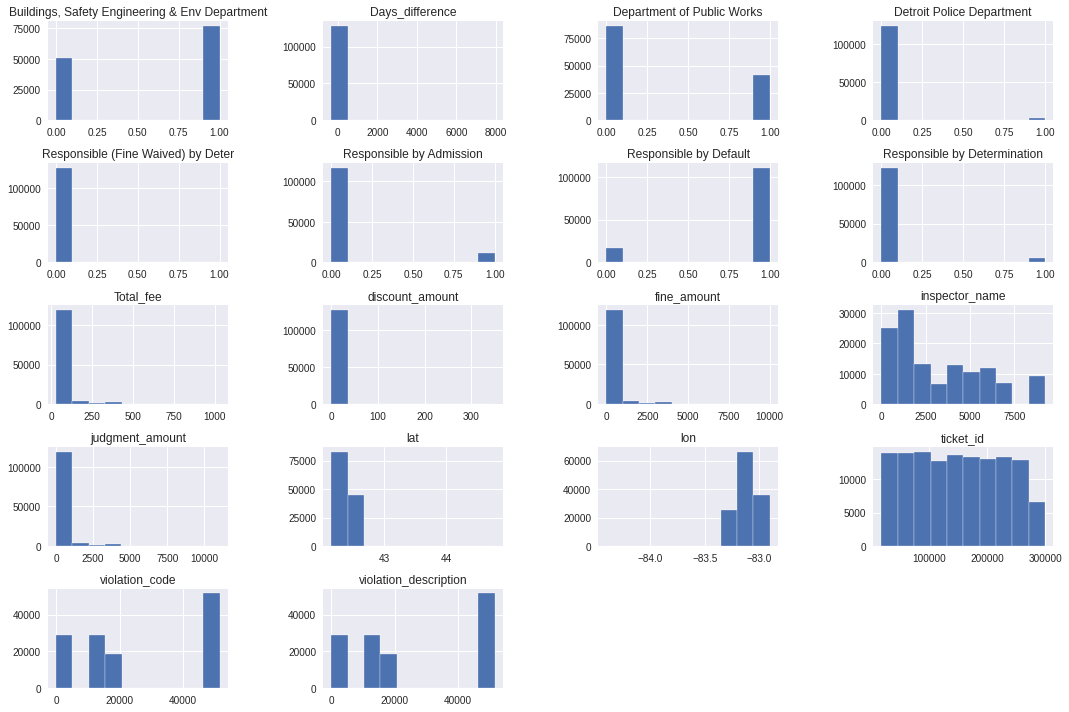

In [24]:
# Visualizing the distribution of data in our train dataset.

X_train.hist(figsize=(15,10));
plt.tight_layout()

In [25]:
# Checking if both train and test set has equal percentage of 0 and 1.

print(y_train.value_counts())
print(y_test.value_counts())

0.00    118569
1.00      9143
Name: compliance, dtype: int64
0.00    29642
1.00     2286
Name: compliance, dtype: int64


**Trying feature selection using different techniques**

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc,f1_score,confusion_matrix,roc_auc_score,accuracy_score

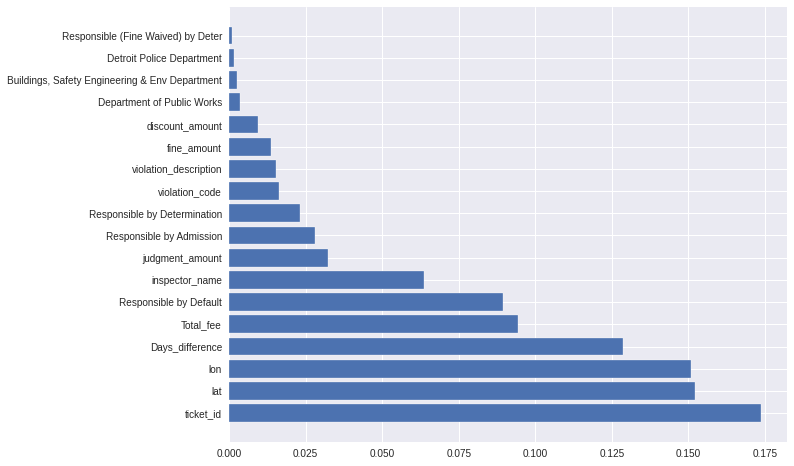

In [27]:
# Fitting a RandomForestClassifier to the train data to find out feature importance. 

clf=RandomForestClassifier(class_weight='balanced',n_jobs=-1)
clf.fit(X_train,y_train)

# Feature importance as per  RandomForestClassifier.

plt.figure(figsize=(10,8))
my_dict={k:v for (k,v) in zip(X_train.columns ,clf.feature_importances_)}
result=dict(sorted(my_dict.items(),key=lambda x:x[1],reverse=True))
plt.barh(y=list(result.keys()) , width=result.values());

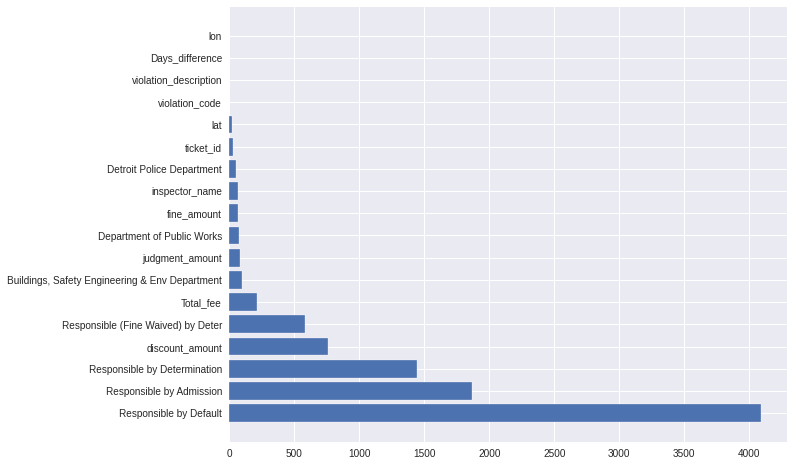

In [28]:
# Feature scores based on ANOVA test

from sklearn.feature_selection import chi2,SelectKBest,f_classif
result=SelectKBest(score_func=f_classif,k=10).fit(X_test,y_test)
my_dict={k:v for (k,v) in zip(X_test.columns,result.scores_)}
result=dict(sorted(my_dict.items(),key=lambda x:x[1],reverse=True))
plt.figure(figsize=(10,8))
plt.barh(y=list(result.keys()) , width=result.values());

<BarContainer object of 19 artists>

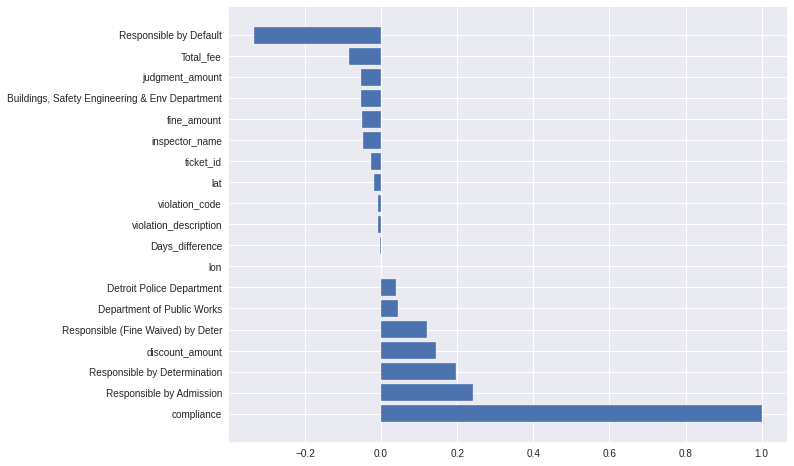

In [29]:
# Feature scores based on correlation with the target value.

new_df=pd.concat([X_train,y_train],axis=1)
result=new_df.corr().loc[:,'compliance'].sort_values(ascending=False)
plt.figure(figsize=(10,8))
plt.barh(y=list(result.index) , width=result.values)

**Training different ML models and evaluating it.**

In [0]:
def custom_evaluation(clf,X_test,y_test):
  '''This function takes the classifier,X_test 
  and y_test as input and print its evaluation scores'''

  y_predicted=clf.predict(X_test)
  predict_proba_output=clf.predict_proba(X_test)[:,1]
  print('auc_score :{:.2f} '.format(roc_auc_score(y_test,predict_proba_output)))
  print('F1 score:{:.2f} '.format(f1_score(y_test,y_predicted)))
  print('Accuracy:{:.2f} '.format(accuracy_score(y_test,y_predicted)))
  print('Confusion_matrix:\n',confusion_matrix(y_test,y_predicted))

In [31]:
# Finding best hyperparameters using gridsearchCV and evaluating our LogisticRegression model.

from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(class_weight='balanced',n_jobs=-1)
grid_param={'penalty':['l1','l2'],'C':[0.5,1,10]}
grid=GridSearchCV(lr,param_grid=grid_param,scoring='roc_auc',cv=3,refit=True)
grid.fit(X_train,y_train)
custom_evaluation(grid,X_test,y_test)

auc_score :0.75 
F1 score:0.25 
Accuracy:0.72 
Confusion_matrix:
 [[21657  7985]
 [  832  1454]]


In [32]:
# Finding best hyperparameters using gridsearchCV and evaluating our GradientBoostingClassifier model.

from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier(random_state=12)
grid_param={'n_estimators':[150,200],'learning_rate':[0.1,0.5]}
grid=GridSearchCV(gbc,param_grid=grid_param,scoring='roc_auc',cv=2,refit=True)
grid.fit(X_train,y_train)
custom_evaluation(grid,X_test,y_test)

auc_score :0.83 
F1 score:0.39 
Accuracy:0.94 
Confusion_matrix:
 [[29565    77]
 [ 1708   578]]


In [33]:
# Fitting GaussianNB classifier to our train data and evaluating it .

from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB().fit(X_train,y_train)
custom_evaluation(gnb,X_test,y_test)

auc_score :0.65 
F1 score:0.13 
Accuracy:0.92 
Confusion_matrix:
 [[29284   358]
 [ 2106   180]]


In [34]:
# Finding best hyperparameters using gridsearchCV and evaluating our randomforestclassifier model.

rfc=RandomForestClassifier(class_weight='balanced',n_jobs=-1,oob_score=True)
grid_param={'n_estimators':[150,200],'max_depth':[5,10]}
grid=GridSearchCV(rfc,param_grid=grid_param,scoring='roc_auc',cv=2,refit=True)
grid.fit(X_train,y_train)
custom_evaluation(grid,X_test,y_test)

auc_score :0.83 
F1 score:0.39 
Accuracy:0.87 
Confusion_matrix:
 [[26232  3410]
 [  897  1389]]


In [35]:
# Out of all the above models that we have tried. GradientBoostingClassifier performed the best with
# AUC score of 0.83 ,accuracy of 0.94 and F1 score of 0.39. RandomForestClassifier also performed good but 
# as Precision is more in GBclassifier as compared to RFclassifier(which has more recall as compared to GBClasifier) 
# we will go ahead with GBclassifier.So now we will train our model with the full data and the best hyperparameters 
# found above and test it with the seperate test set provided .

X_train_whole=pd.concat([X_train,X_test],axis=0)
y_train_whole=pd.concat([y_train,y_test],axis=0)

from sklearn.ensemble import GradientBoostingClassifier
gbc_model=GradientBoostingClassifier(n_estimators=200,learning_rate=0.5,random_state=12)
gbc_model.fit(X_train_whole,y_train_whole)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=12, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [36]:
from sklearn.model_selection import cross_val_score
mean_cross_validation_score=np.mean(cross_val_score(gbc_model,X_train_whole,y_train_whole,scoring='roc_auc',cv=3))
print('Mean cross validation score (AUC) :{}'.format(mean_cross_validation_score))

Mean cross validation score (AUC) :0.827465519423404


**Prediction on a seperate test set using our trained model.**

In [37]:
# Reading our test dataset and reducing its size.

testing_df=pd.read_csv('/content/drive/My Drive/test.csv',encoding='ISO-8859-1',parse_dates=['ticket_issued_date','hearing_date'])
x=pd.merge(testing_df,address_df,on='ticket_id',how='left')
testing_df=pd.merge(x,latlon_df,on='address',how='left')
testing_df=reduce_memory(testing_df)

Final DataFrame memory_usage:10.820566177368164
 Total memory saved (%): 25.0
Total time taken to reduce DataFrame : 22.548437118530273 ms


In [0]:
def testing_custom_preprocessing(df):
  ''' This function take dataframe as a input, 
      performs preprocesing on it and then returns it as a dataframe.'''
  
  # Droping the columns which has more than 75 % Nan values as it will make
  # the feature space very sparse and also won't provide any useful information in prediction.
  df.drop(['grafitti_status','non_us_str_code','violation_zip_code'],axis=1,inplace=True)
  
  # Converting columns data type to 'category' for columns which has less than 300 unique values.
  for i in df.columns:
    if str(df[i].dtype) == 'object' and df[i].nunique()<300:
      df[i]=df[i].astype('category')

  # Droping 'clean_up_cost' column as it has only one unique value (constant for all data)
  # and so variance is zero and therefore wont provide any useful information in prediction . 
  df.drop('clean_up_cost',axis=1,inplace=True)

  # Creating new colummn-Total_fee as the sum of admin_fee,state_fee and late_fee and dropping the old columns .
  df['Total_fee']=df['admin_fee']+df['state_fee']+df['late_fee']
  df.drop(['admin_fee','state_fee','late_fee'],axis=1,inplace=True)

  # Removing outliers in country column and then droping Country column as it is constant (USA)
  df.drop('country',inplace=True,axis=1)

  # Droping address ,city,state,zip_code column as its information is already there in lat and lon column .
  # Droping violator_name column as there are more than 50% unique value and i feel it wont provide any useful information in prediction. 
  df.drop(['violation_street_number','violation_street_name','address','violator_name','state','zip_code','city','mailing_address_str_name','mailing_address_str_number'],axis=1,inplace=True)

  return df

In [0]:
testing_df=testing_custom_preprocessing(testing_df)

In [0]:
def testing_custom_encoding(test_df):
  '''This function take test dataframe as a input, 
      performs encoding of the categorical features and then returns it as a dataframe. '''

  # Filling Nan values in hearing_date column with most frequent hearing date
  # (mode)and creating a new feature-Days_difference which is the difference of hearing_date and ticket_issued_date
  mode=list(stats.mode(test_df['hearing_date']))[0][0]
  test_df['hearing_date'].fillna(value=mode,inplace=True)
  test_df['Days_difference']=test_df['hearing_date']-test_df['ticket_issued_date']
  test_df['Days_difference']=test_df['Days_difference'].dt.days
  test_df.drop(['ticket_issued_date','hearing_date'],axis=1,inplace=True)

  # Encoding the column with the counts of each unique name.This will not make
  # the feature space sparse when there are more number of unique catgorical values
  my_map=test_df['inspector_name'].value_counts().to_dict()
  test_df['inspector_name']=test_df['inspector_name'].map(my_map)

  my_map1=test_df['violation_description'].value_counts().to_dict()
  test_df['violation_description']=test_df['violation_description'].map(my_map1)

  my_map2=test_df['violation_code'].value_counts().to_dict()
  test_df['violation_code']=test_df['violation_code'].map(my_map2)

  # Encoding disposition column like OneHotEncoder but only for the top 4 values.
  my_list=test_df['disposition'].value_counts().head(4).index
  for i in my_list:
    test_df[i]=np.where(test_df['disposition']==i,1,0)
  test_df.drop('disposition',axis=1,inplace=True)

  # Encoding agency_name column like OneHotEncoder but only for the top 4 values
  my_list1=test_df['agency_name'].value_counts().head(4).index
  for i in my_list1:
    test_df[i]=np.where(test_df['agency_name']==i,1,0)
  test_df.drop('agency_name',axis=1,inplace=True)
  test_df['lat'].fillna(value=list(stats.mode(test_df['lat']))[0][0],inplace=True)
  test_df['lon'].fillna(value=list(stats.mode(test_df['lon']))[0][0],inplace=True)

  return test_df

In [0]:
testing_df=testing_custom_encoding(testing_df)

In [42]:
# Predicting the probabality of getting 0 and 1 using our final trained model 

final_predict_proba_result=pd.Series(gbc_model.predict_proba(testing_df)[:,1],testing_df.ticket_id)
final_predict_proba_result

ticket_id
284932   0.02
285362   0.00
285361   0.01
285338   0.01
285346   0.01
         ... 
376496   0.03
376497   0.03
376499   0.22
376500   0.22
369851   0.99
Length: 61001, dtype: float64

**Dumping of our final trained model to pickle file**

In [43]:
# Dumping our final model to pickle file.

from sklearn.externals import joblib
joblib.dump(gbc_model,'BlightPrediction_model.pk1')

['BlightPrediction_model.pk1']